In [96]:
import os
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Below are steps taken to clean the original EPA data and use the same dataset from the original notebook. 

In [97]:
# Load the EPA Smart Location Database.
epa_df = pd.read_csv('EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

print(f"Original EPA dataset shape: {epa_df.shape}")
print(f"Columns: {len(epa_df.columns)}")
print('-' * 50)

# Filter for Charlotte-Mecklenburg County (STATEFP=37 for NC, COUNTYFP=119 for Mecklenburg).
charlotte_df_research = epa_df[(epa_df['STATEFP'] == 37) & (epa_df['COUNTYFP'] == 119)].copy()

print(f"Charlotte dataset shape: {charlotte_df_research.shape}")
print('-' * 50)

# Create FIPS12 column by combining geographic components.
charlotte_df_research['fips12'] = charlotte_df_research['STATEFP'].astype(str).str.zfill(2) + \
                                 charlotte_df_research['COUNTYFP'].astype(str).str.zfill(3) + \
                                 charlotte_df_research['TRACTCE'].astype(str).str.zfill(6) + \
                                 charlotte_df_research['BLKGRPCE'].astype(str).str.zfill(1)

# Create tract-block group identifier for easier reference.
charlotte_df_research['TRACT_BLKGRP'] = charlotte_df_research['TRACTCE'].astype(str) + '-' + \
                                       charlotte_df_research['BLKGRPCE'].astype(str)

# Select relevant columns.
columns_to_keep = [
    # Geographic identifiers
    'OBJECTID', 'GEOID10', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'fips12', 'TRACT_BLKGRP',
    # Demographics
    'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'AutoOwn0', 'Pct_AO0',
    # Employment - Total and by sector (8-tier classification)
    'TotEmp', 'E8_Ret', 'E8_off', 'E8_Ind', 'E8_Svc', 'E8_Ent', 'E8_Ed', 'E8_Hlth', 'E8_Pub',
    # Employment - 5-tier classification
    'E5_Ret', 'E5_Off', 'E5_Ind', 'E5_Svc', 'E5_Ent',
    # Wage levels
    'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'E_PctLowWage',
    # Employment density
    'D1C5_RET', 'D1C5_OFF', 'D1C5_IND', 'D1C5_SVC', 'D1C5_ENT',
    'D1C8_RET', 'D1C8_OFF', 'D1C8_IND', 'D1C8_SVC', 'D1C8_ENT', 'D1C8_ED', 'D1C8_HLTH', 'D1C8_PUB',
    # Employment diversity
    'D2B_E5MIX', 'D2B_E8MIX', 'D2R_JOBPOP',
    # Transit access measures
    'D4B025', 'D4B050', 'D4C', 'D4D',
    # Accessibility measures (45-minute reach)
    'D5AR', 'D5AE', 'D5BR', 'D5BE',
    # Relative accessibility
    'D5DR', 'D5DRI',
    # Walkability
    'NatWalkInd'
]

# Filter to keep only the selected columns.
charlotte_df_research = charlotte_df_research[columns_to_keep]

# Remove rows with missing values in key variables.
charlotte_df_research = charlotte_df_research.dropna(subset=['TotEmp', 'D4B050', 'D4B025', 'D5AR', 'D5BR'])

print(f"Final cleaned dataset shape: {charlotte_df_research.shape}")
print(f"Total employment in Charlotte: {charlotte_df_research['TotEmp'].sum():,}")
print(f"Total population in Charlotte: {charlotte_df_research['TotPop'].sum():,}")
print('-' * 50)

# Display dataset head to verify.
display(charlotte_df_research[['fips12', 'TotEmp', 'D4B050', 'D4B025', 'Pct_AO0', 'E_PctLowWage']].head())

Original EPA dataset shape: (220740, 117)
Columns: 117
--------------------------------------------------
Charlotte dataset shape: (555, 117)
--------------------------------------------------
Final cleaned dataset shape: (555, 59)
Total employment in Charlotte: 712,605
Total population in Charlotte: 1,054,314
--------------------------------------------------


,fips12,TotEmp,D4B050,D4B025,Pct_AO0,E_PctLowWage
164321,371190019162,225,0.0,0.0,0.074975,0.542222
164361,371190064042,731,0.0,0.0,0.000000,0.294118
164362,371190059143,3909,0.0,0.0,0.032020,0.130724
164363,371190062041,606,0.0,0.0,0.017995,0.250825
164364,371190063023,2282,0.0,0.0,0.000000,0.391323


In [98]:
# Assign to df1 for compatibility with existing code.
df1 = charlotte_df_research.copy()
df1[["fips12", "D4B050", "D4B025"]]

,fips12,D4B050,D4B025
164321,371190019162,0.000000,0.000000
164361,371190064042,0.000000,0.000000
164362,371190059143,0.000000,0.000000
164363,371190062041,0.000000,0.000000
164364,371190063023,0.000000,0.000000
...,...,...,...
170212,371190039031,0.000000,0.000000
170213,371190038061,0.000000,0.000000
170214,371190058374,0.000000,0.000000
170241,371190064072,0.000000,0.000000


In [99]:
# Rank CBGs by % of jobs within ½ mile of fixed-guideway transit stops (D4B050)
low_access_D4B050 = df1[["fips12", "TotEmp", "D4B050"]].sort_values(by="D4B050", ascending=True)

# Rank CBGs by % of jobs within ¼ mile of fixed-guideway transit stops (D4B025)
low_access_D4B025 = df1[["fips12", "TotEmp", "D4B025"]].sort_values(by="D4B025", ascending=True)

In [100]:
# Count how many CBGs have 0% of jobs within ½ mile of fixed-guideway transit.
num_zero_D4B050 = (df1["D4B050"] == 0).sum()

# Count how many CBGs have 0% of jobs within ¼ mile of any transit stop.
num_zero_D4B025 = (df1["D4B025"] == 0).sum()

print(f"CBGs with 0% of jobs near fixed-guideway transit (D4B050): {num_zero_D4B050}")
print(f"CBGs with 0% of jobs near fixed-guideway transit (D4B025): {num_zero_D4B025}")

CBGs with 0% of jobs near fixed-guideway transit (D4B050): 463
CBGs with 0% of jobs near fixed-guideway transit (D4B025): 483


- Threshold checks for fixed-guideway access:

In [101]:
# For ¼ mile (D4B025)
cbgs_over_025_D4B025 = (df1["D4B025"] >= 0.25).sum()
cbgs_over_050_D4B025 = (df1["D4B025"] >= 0.50).sum()
cbgs_over_075_D4B025 = (df1["D4B025"] >= 0.75).sum()

# For ½ mile (D4B050)
cbgs_over_025_D4B050 = (df1["D4B050"] >= 0.25).sum()
cbgs_over_050_D4B050 = (df1["D4B050"] >= 0.50).sum()
cbgs_over_075_D4B050 = (df1["D4B050"] >= 0.75).sum()

# Print results
print("¼ Mile Fixed-Guideway Transit Access (D4B025):")
print(f"CBGs with ≥ 25% of jobs near transit: {cbgs_over_025_D4B025}")
print(f"CBGs with ≥ 50% of jobs near transit: {cbgs_over_050_D4B025}")
print(f"CBGs with ≥ 75% of jobs near transit: {cbgs_over_075_D4B025}")

print("\n½ Mile Fixed-Guideway Transit Access (D4B050):")
print(f"CBGs with ≥ 25% of jobs near transit: {cbgs_over_025_D4B050}")
print(f"CBGs with ≥ 50% of jobs near transit: {cbgs_over_050_D4B050}")
print(f"CBGs with ≥ 75% of jobs near transit: {cbgs_over_075_D4B050}")


¼ Mile Fixed-Guideway Transit Access (D4B025):
CBGs with ≥ 25% of jobs near transit: 23
CBGs with ≥ 50% of jobs near transit: 11
CBGs with ≥ 75% of jobs near transit: 6

½ Mile Fixed-Guideway Transit Access (D4B050):
CBGs with ≥ 25% of jobs near transit: 68
CBGs with ≥ 50% of jobs near transit: 51
CBGs with ≥ 75% of jobs near transit: 24


In [102]:
# Define Underserved Proportion.
df1['Underserved_Proportion'] = 1 - df1['D4B050']

# Multiply underserved proportion by total employment (TotEmp) to get jobs outside ½-mile radius.
df1['Underserved_Jobs'] = (df1['TotEmp'] * (1 - df1['D4B050'])).round().astype(int)

In [103]:
# Priorite High-Gap Areas into new dataframe.
df1_sorted = df1.sort_values(by='Underserved_Jobs', ascending=False)

# Summary Statistics. 
df1[["D4B050", "D4B025"]].describe()

,D4B050,D4B025
count,555.000000,555.000000
mean,0.084897,0.032927
std,0.233987,0.126092
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,0.999903


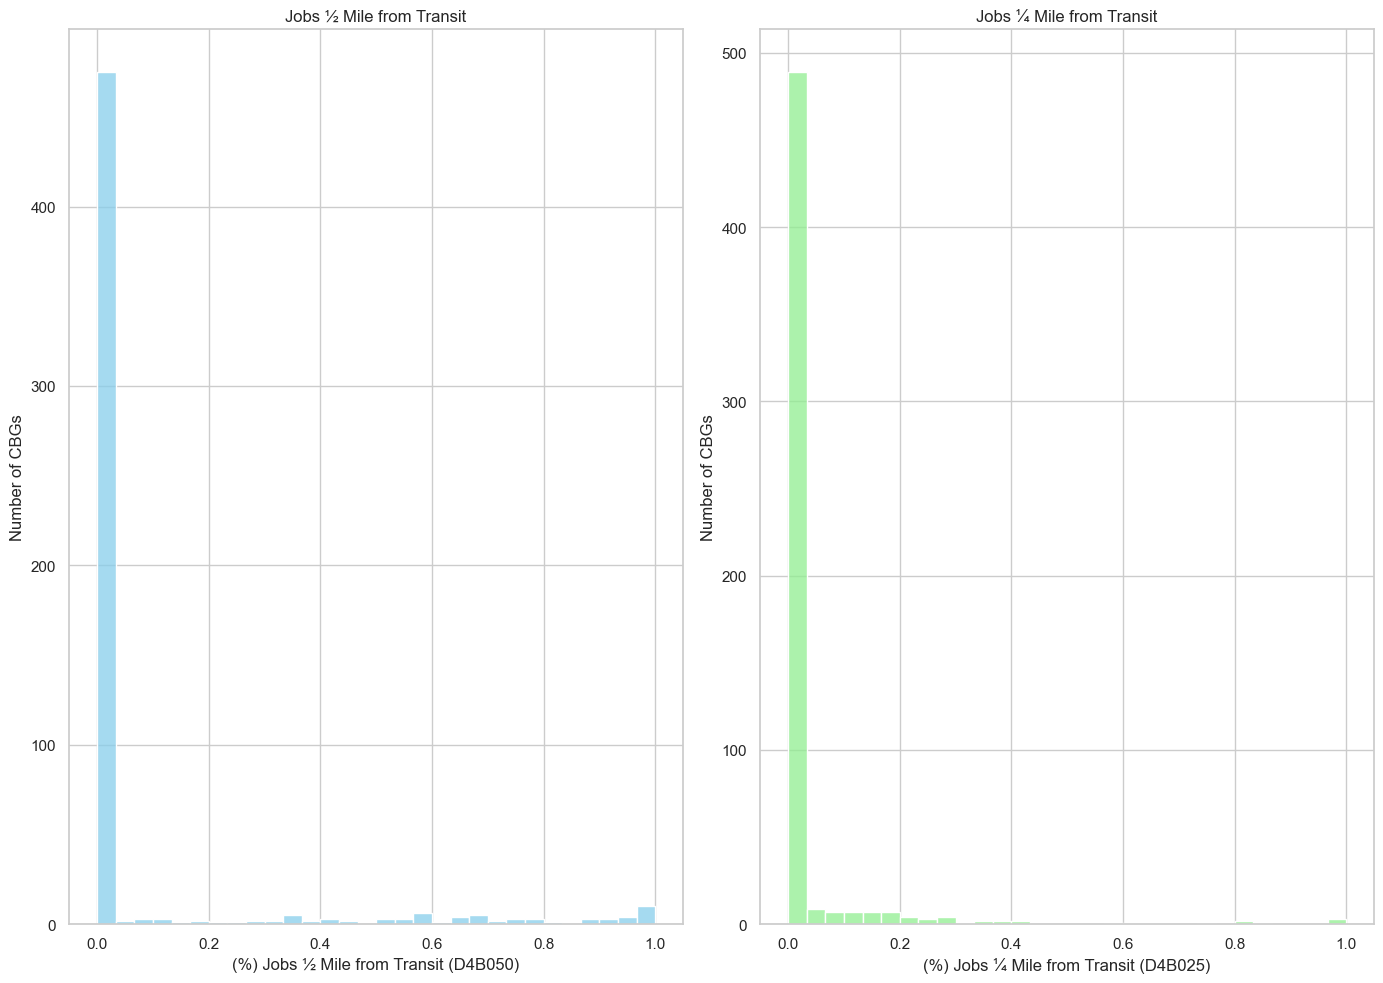

In [104]:
# Visualize distribution of employment within 1/2 mile transit.
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Histogram for D4B050
sns.histplot(df1["D4B050"], bins=30, kde=False, ax=axes[0], color="skyblue")
axes[0].set_title("Jobs ½ Mile from Transit")
axes[0].set_xlabel("(%) Jobs ½ Mile from Transit (D4B050)")
axes[0].set_ylabel("Number of CBGs")
axes[0].set_facecolor("#ffffff")

# Histogram for D4B025
sns.histplot(df1["D4B025"], bins=30, kde=False, ax=axes[1], color="lightgreen")
axes[1].set_title("Jobs ¼ Mile from Transit")
axes[1].set_xlabel("(%) Jobs ¼ Mile from Transit (D4B025)")
axes[1].set_ylabel("Number of CBGs")
axes[1].set_facecolor("#ffffff")

fig.set_facecolor("#ffffff")
plt.tight_layout()
plt.show()


In [105]:
# Remove empty CBG and verify nulls.
df1_sorted = df1_sorted[df1_sorted["TotEmp"] > 0].copy()
df1_sorted.isna().sum()

OBJECTID                  0
GEOID10                   0
STATEFP                   0
COUNTYFP                  0
TRACTCE                   0
                         ..
D5DR                      0
D5DRI                     0
NatWalkInd                0
Underserved_Proportion    0
Underserved_Jobs          0
Length: 61, dtype: int64

---
**KMeans Clustering**

In [106]:
# Define employment columns
employment_columns = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]

# Calculate percentages
for col in employment_columns:
    df1_sorted[f"{col}_pct"] = (df1_sorted[col] / df1_sorted["TotEmp"]) * 100

# View the results
print(df1_sorted[[f"{col}_pct" for col in employment_columns]].head())

# KMeans Clustering
X = df1_sorted[[f"{col}_pct" for col in employment_columns]]
kmeans = KMeans(n_clusters=4).fit(X)
df1_sorted["job_cluster"] = kmeans.labels_

        E8_Ret_pct  E8_off_pct  E8_Ind_pct  E8_Svc_pct  E8_Ent_pct  E8_Ed_pct  \
164451    1.450346    1.242494    0.812933    4.545035    3.644342   1.191686   
169969    6.313131   41.440446    7.112795   28.924663    8.433291   0.946970   
165713    0.455996    3.055176   86.166211    4.936161    3.385773   0.017100   
165018    0.096074   53.455454   10.504067   27.688465    1.511561   2.004740   
169412    0.086207   89.913793    5.380747    3.211207    0.854885   0.000000   

        E8_Hlth_pct  E8_Pub_pct  
164451    87.113164         0.0  
169969     6.828704         0.0  
165713     1.983584         0.0  
165018     4.739640         0.0  
169412     0.553161         0.0  


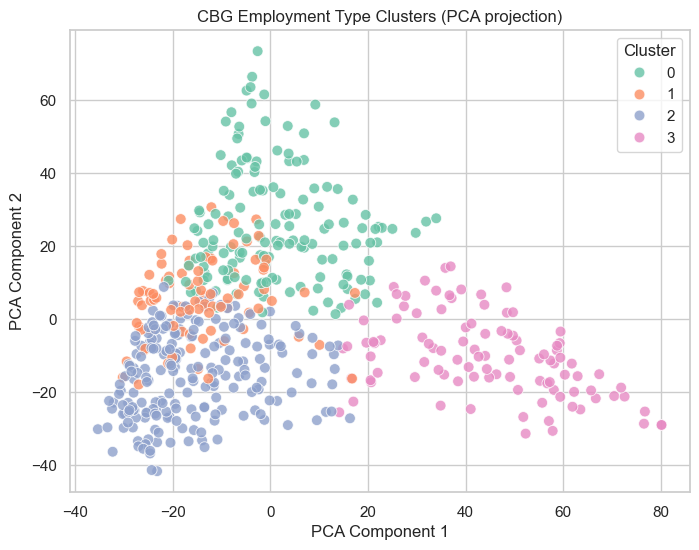

In [107]:
# Just keep pct columns.
pct_cols = [f"{col}_pct" for col in employment_columns]

# Reduce to 2D.
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df1_sorted[pct_cols])

# Add to df for plotting.
df1_sorted["pca1"] = pca_result[:, 0]
df1_sorted["pca2"] = pca_result[:, 1]

# Plot with seaborn.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df1_sorted,
    x="pca1",
    y="pca2",
    hue="job_cluster",
    palette="Set2",
    s=60,
    alpha=0.8
)
plt.title("CBG Employment Type Clusters (PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [108]:
# Load the block group shapefile for NC.
block_groups = gpd.read_file("tl_2019_37_bg.shp") 

# Filter only Mecklenburg County (CountyFP = 119).
block_groups = block_groups[block_groups["COUNTYFP"] == "119"]

# Create 12-digit FIPS (GEOID) column.
block_groups["fips12"] = block_groups["GEOID"]

# Merge on the 12-digit FIPS code.
block_groups["fips12"] = block_groups["fips12"].astype(str)
df1_sorted["fips12"] = df1_sorted["fips12"].astype(str)
merged = block_groups.merge(df1_sorted, on="fips12", how="left")

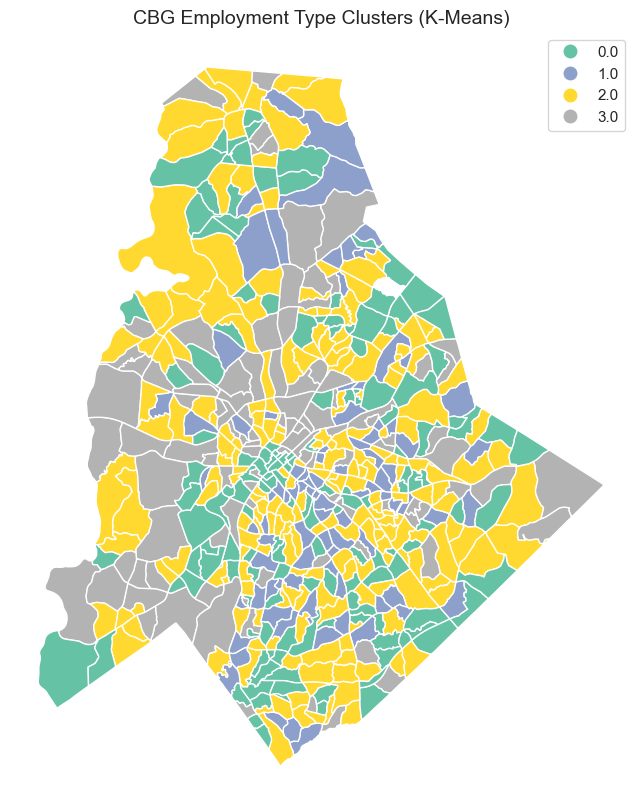

In [109]:
# KMeans Clustering for job types. 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='job_cluster', categorical=True, legend=True, cmap='Set2', ax=ax)
ax.set_title("CBG Employment Type Clusters (K-Means)", fontsize=14)
plt.axis("off")
plt.show()

In [110]:
# Emplyoment distribution accross CBGs.
employment_columns = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]

# Calculate percentages.
for col in employment_columns:
    df1_sorted[f"{col}_pct"] = (df1_sorted[col] / df1_sorted["TotEmp"]) * 100

# View the results.
print(df1_sorted[[f"{col}_pct" for col in employment_columns]].head())

        E8_Ret_pct  E8_off_pct  E8_Ind_pct  E8_Svc_pct  E8_Ent_pct  E8_Ed_pct  \
164451    1.450346    1.242494    0.812933    4.545035    3.644342   1.191686   
169969    6.313131   41.440446    7.112795   28.924663    8.433291   0.946970   
165713    0.455996    3.055176   86.166211    4.936161    3.385773   0.017100   
165018    0.096074   53.455454   10.504067   27.688465    1.511561   2.004740   
169412    0.086207   89.913793    5.380747    3.211207    0.854885   0.000000   

        E8_Hlth_pct  E8_Pub_pct  
164451    87.113164         0.0  
169969     6.828704         0.0  
165713     1.983584         0.0  
165018     4.739640         0.0  
169412     0.553161         0.0  


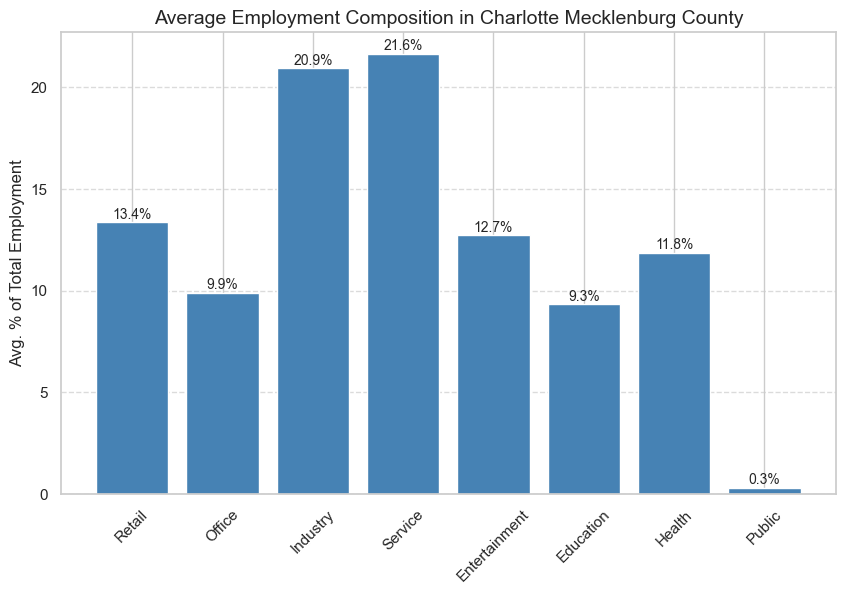

In [111]:
# Loop through employment category and calculate mean percentage across all underserved CBGs.
employment_columns = {
    col: df1_sorted[f"{col}_pct"].mean()
    for col in ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
}

# Create mapping for readable labels.
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

# Plot as bar chart.
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111) 
ax.set_facecolor('#ffffff') 
fig.set_facecolor('#ffffff')  

plt.bar([label_mapping[key] for key in employment_columns.keys()], employment_columns.values(), color="steelblue")
plt.title("Average Employment Composition in Charlotte Mecklenburg County", fontsize=14)
plt.ylabel("Avg. % of Total Employment", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, (label, value) in enumerate(employment_columns.items()):
    plt.text(i, value + 0.2, f"{value:.1f}%", ha='center', fontsize=10)

plt.show()

---

**Distribution of Employment Composition in No-Transit-Access CBGs**

In [112]:
# Filter only the underserved CBGs: 100% of jobs are not within transit.
underserved_cbgs = df1_sorted[df1_sorted["Underserved_Proportion"] == 1.0].copy()

# Define employment columns.
employment_columns = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]

# Calculate percentages.
for col in employment_columns:
    underserved_cbgs[f"{col}_pct"] = (underserved_cbgs[col] / underserved_cbgs["TotEmp"]) * 100

# View the results.
print(underserved_cbgs[[f"{col}_pct" for col in employment_columns]].head())

        E8_Ret_pct  E8_off_pct  E8_Ind_pct  E8_Svc_pct  E8_Ent_pct  E8_Ed_pct  \
164451    1.450346    1.242494    0.812933    4.545035    3.644342   1.191686   
169969    6.313131   41.440446    7.112795   28.924663    8.433291   0.946970   
165713    0.455996    3.055176   86.166211    4.936161    3.385773   0.017100   
165018    0.096074   53.455454   10.504067   27.688465    1.511561   2.004740   
169412    0.086207   89.913793    5.380747    3.211207    0.854885   0.000000   

        E8_Hlth_pct  E8_Pub_pct  
164451    87.113164         0.0  
169969     6.828704         0.0  
165713     1.983584         0.0  
165018     4.739640         0.0  
169412     0.553161         0.0  


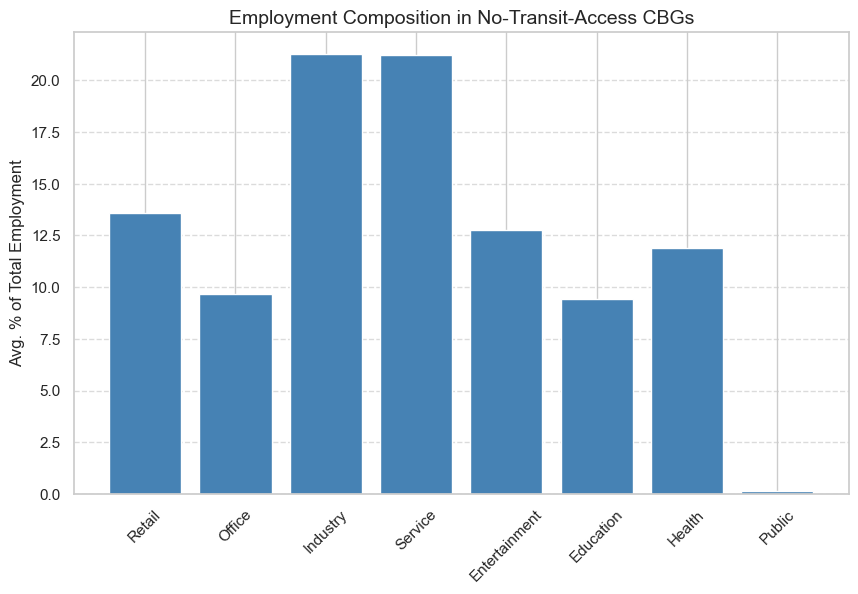

In [113]:
# Calculate averages for each percentage column.
average_employment_pct = {
    col: underserved_cbgs[f"{col}_pct"].mean()
    for col in ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
}

# Create mapping for readable labels.
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

plt.figure(figsize=(10, 6))

plt.bar([label_mapping[key] for key in average_employment_pct.keys()], average_employment_pct.values(), color="steelblue")
plt.title("Employment Composition in No-Transit-Access CBGs", fontsize=14)
plt.ylabel("Avg. % of Total Employment", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

---

**Employment Composition Across High-Employment, Low-Transit-Access CBGs.**

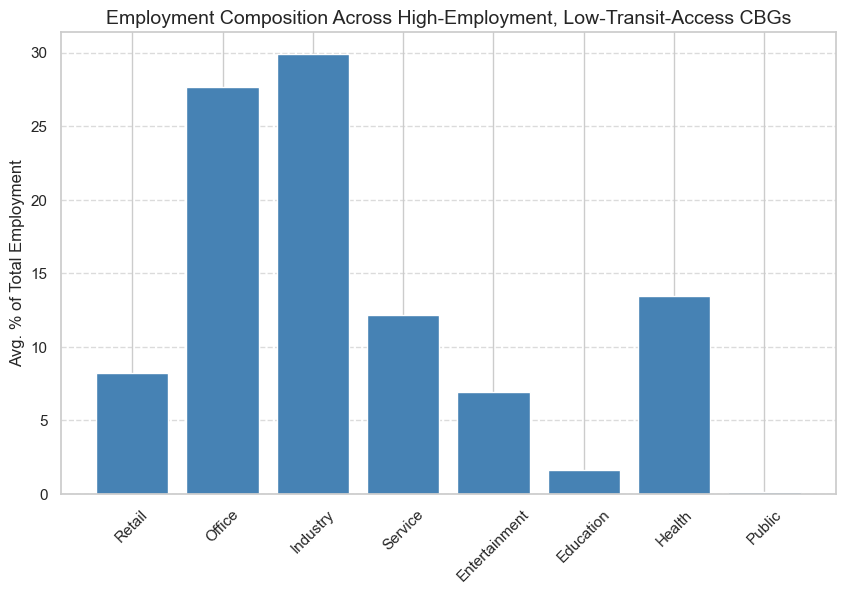

In [114]:
# Filter only the underserved CBGs.
underserved_cbgs = merged[(merged["D4B050"] < .3) & (merged["TotEmp"] > 10000)].copy()

# Define employment columns.
employment_columns = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]

# Calculate percentages.
for col in employment_columns:
    underserved_cbgs[f"{col}_pct"] = (underserved_cbgs[col] / underserved_cbgs["TotEmp"]) * 100

# Loop through each employment category and calculate the mean percentage across all underserved CBGs.
average_employment_pct = {
    col: underserved_cbgs[f"{col}_pct"].mean()
    for col in ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
}

# Create mapping for readable labels.
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

# Plot the data as a bar chart.
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_facecolor('#ffffff')
fig.set_facecolor('#ffffff') 

plt.bar([label_mapping[key] for key in average_employment_pct.keys()], average_employment_pct.values(), color="steelblue") 

plt.title("Employment Composition Across High-Employment, Low-Transit-Access CBGs", fontsize=14)
plt.ylabel("Avg. % of Total Employment", fontsize=12) 
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

---
**Distribution of Employment Composition in No-Transit-Access CBGs**

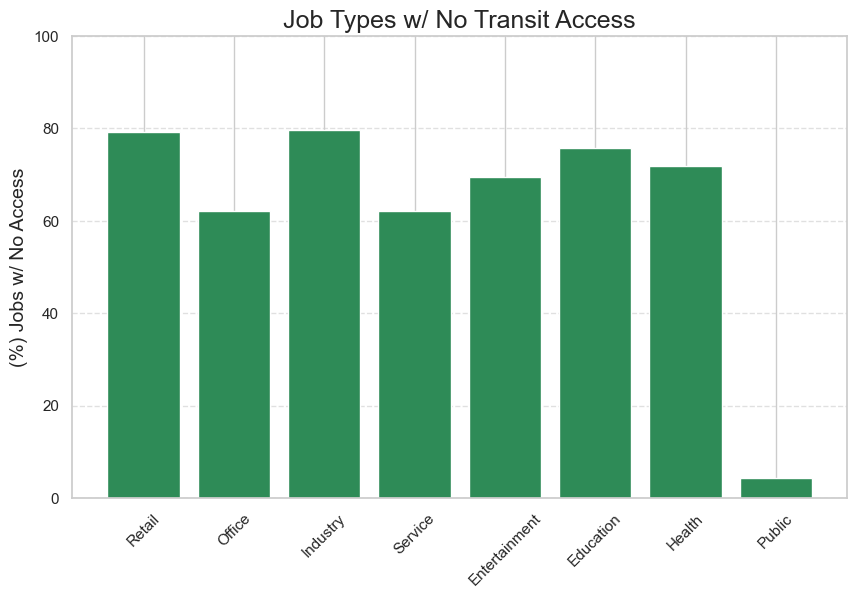

In [115]:
# Define your job columns and a label mapping for readability.
job_cols = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

# Create a mask for CBGs with no transit access.
bad_access_cbgs = df1_sorted[df1_sorted["Underserved_Proportion"] == 1.0]

# Calculate proportion of each job type with no transit access.
results = {}

for col in job_cols:
    total_jobs = df1_sorted[col].sum()
    jobs_wO_access = bad_access_cbgs[col].sum()
    results[col] = (jobs_wO_access / total_jobs) * 100

# Plot the data as a bar chart.
plt.figure(figsize=(10, 6))

plt.bar([label_mapping[key] for key in results.keys()],results.values(), color="seagreen")

plt.ylim(0,100)
plt.title("Job Types w/ No Transit Access", fontsize=18)
plt.ylabel("(%) Jobs w/ No Access", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

---
Calculate total jobs located in these CBGs by job type.
- *Instead of (%) job types out of all jobs with no access, this is (%) of job types out of its category with no access.*

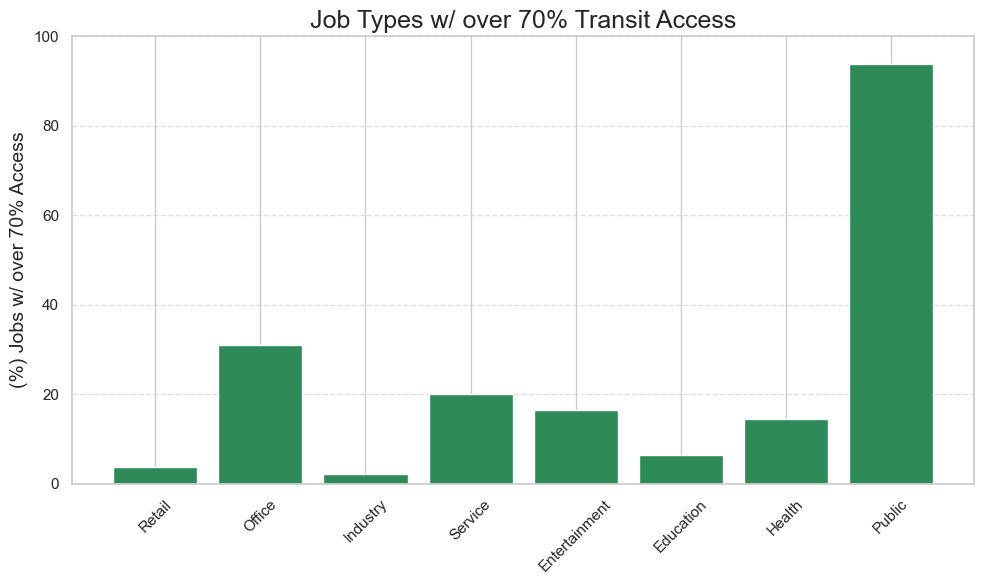

In [116]:
# Define job columns and a label mapping for readability
job_cols = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

# Create a mask for CBGs with no transit access
bad_access_cbgs = df1_sorted[df1_sorted["Underserved_Proportion"] < .3]

# Calculate proportion of each job type with no transit access
results = {}

for col in job_cols:
    total_jobs = df1_sorted[col].sum()
    jobs_wO_access = bad_access_cbgs[col].sum()
    results[col] = (jobs_wO_access / total_jobs) * 100

# Plot the data as a bar chart
plt.figure(figsize=(10, 6))  

plt.bar(
    [label_mapping[key] for key in results.keys()],  
    results.values(), 
    color="seagreen"
) 

plt.ylim(0,100)
plt.title("Job Types w/ over 70% Transit Access", fontsize=18)
plt.ylabel("(%) Jobs w/ over 70% Access", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---
Calculate share of total jobs located in these CBGs by job type.
- *Instead of percent of job types out of all jobs with no access, this is percent of job types out of its category with no access.*

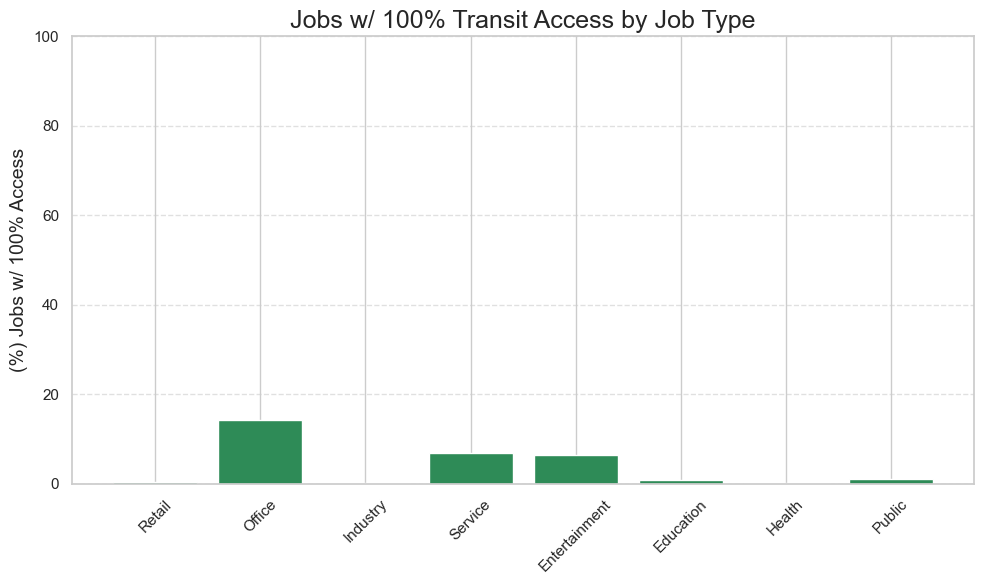

In [117]:
# Define job columns and add label mapping
job_cols = ["E8_Ret", "E8_off", "E8_Ind", "E8_Svc", "E8_Ent", "E8_Ed", "E8_Hlth", "E8_Pub"]
label_mapping = {
    "E8_Ret": "Retail",
    "E8_off": "Office",
    "E8_Ind": "Industry",
    "E8_Svc": "Service",
    "E8_Ent": "Entertainment",
    "E8_Ed": "Education",
    "E8_Hlth": "Health",
    "E8_Pub": "Public"
}

# Create a mask for CBGs with no transit access (adjust threshold if needed)
bad_access_cbgs = df1_sorted[df1_sorted["D4B050"] == 1.00] 

# Calculate proportion of each job type with no transit access
results = {}

for col in job_cols:
    total_jobs = df1_sorted[col].sum()
    jobs_wO_access = bad_access_cbgs[col].sum()
    results[col] = (jobs_wO_access / total_jobs) * 100

# Plot the data as a bar chart
plt.figure(figsize=(10, 6))

plt.bar(
    [label_mapping[key] for key in results.keys()],
    results.values(), 
    color="seagreen"
)
plt.ylim(0,100)
plt.title("Jobs w/ 100% Transit Access by Job Type", fontsize=18)
plt.ylabel("(%) Jobs w/ 100% Access", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


---
## Question 2: Distribution of Job Concentration in Mecklenburg County

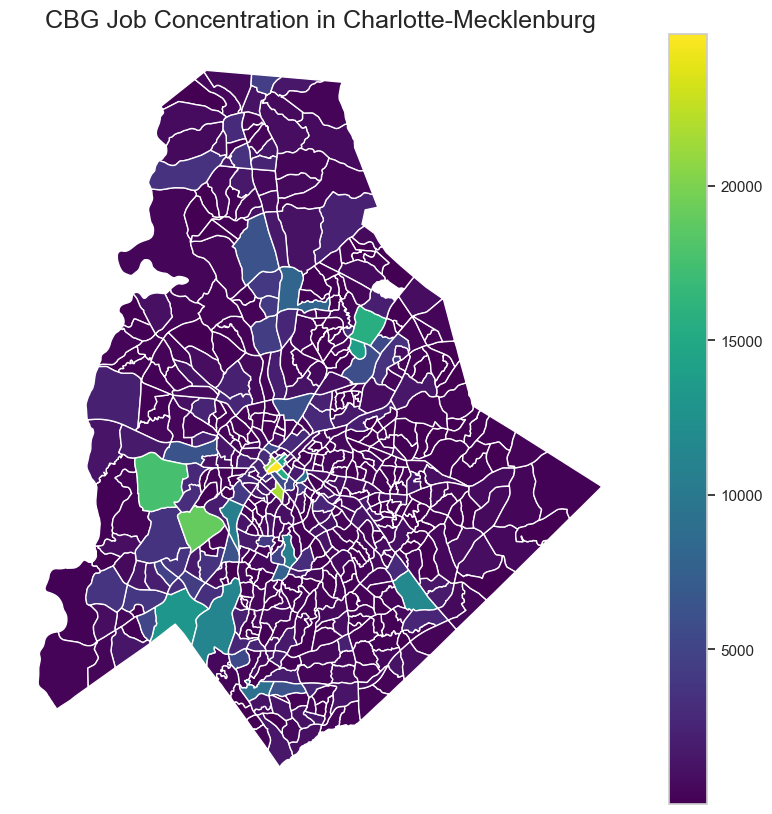

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column="TotEmp", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("CBG Job Concentration in Charlotte-Mecklenburg", fontsize=18)
plt.axis("off")
plt.show()

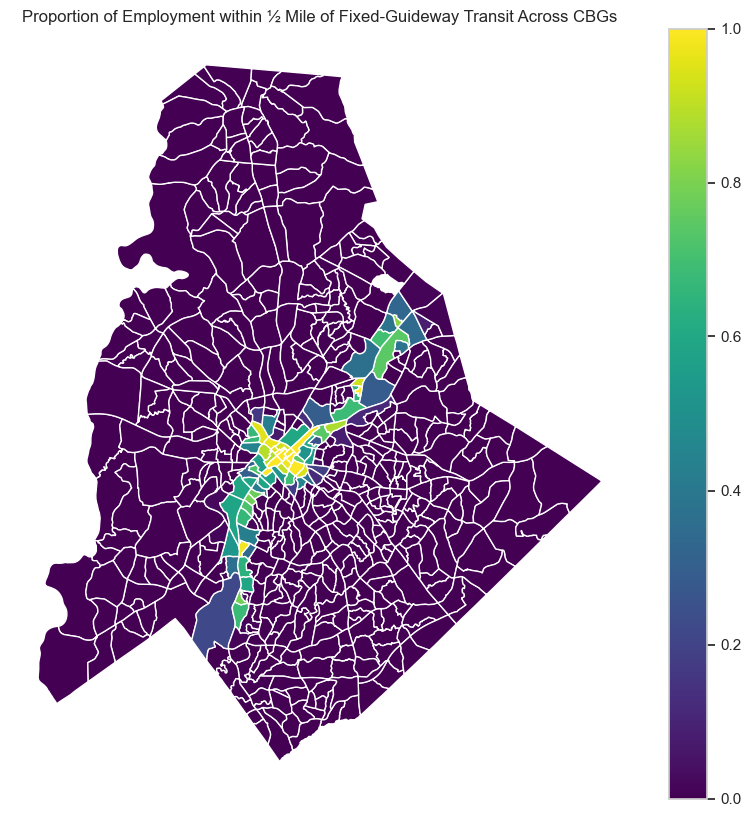

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column="D4B050", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("Proportion of Employment within ½ Mile of Fixed-Guideway Transit Across CBGs")
plt.axis("off")
plt.show()

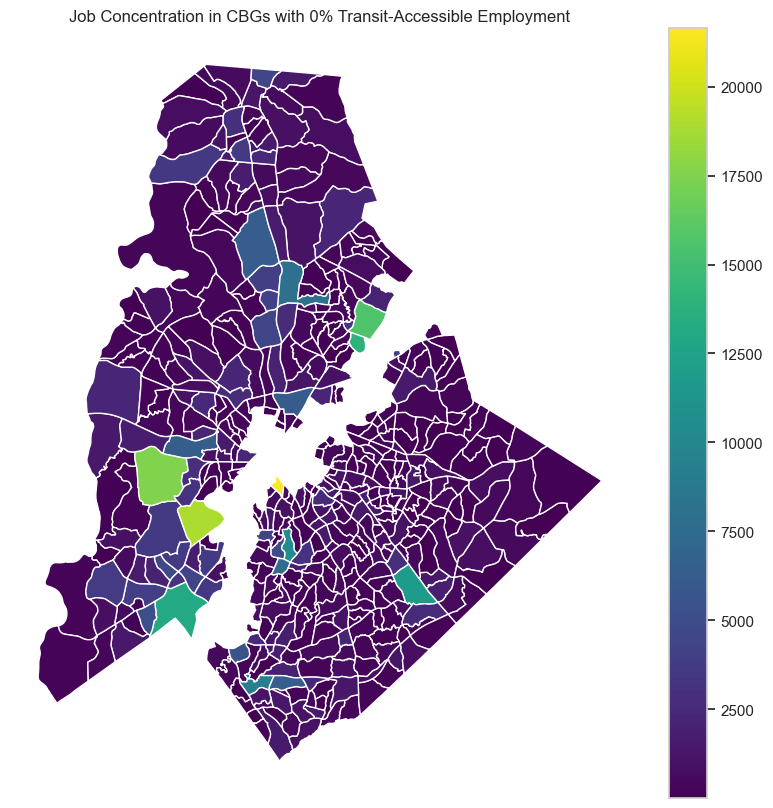

In [120]:
# Filter for CBGs with 0% of employment within ½ mile of fixed-guideway transit
no_transit_access = merged[merged["D4B050"] == 0]

# Plot TotEmp for those CBGs as a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
no_transit_access.plot(column="TotEmp", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("Job Concentration in CBGs with 0% Transit-Accessible Employment")
plt.axis("off")
plt.show()

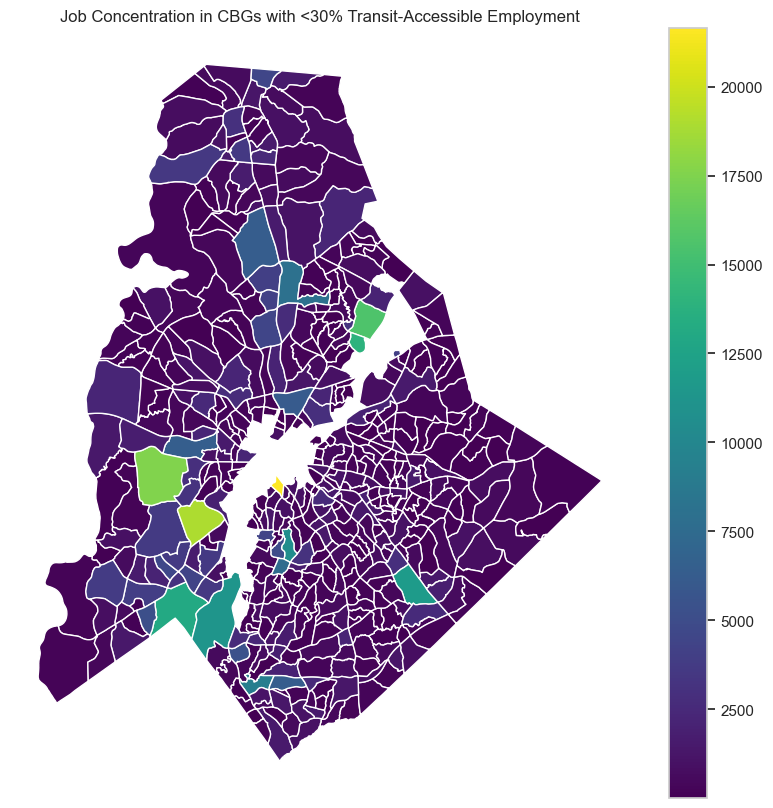

In [121]:
# Filter for CBGs with less than 30% of employment within ½ mile of fixed-guideway transit
low_transit_access = merged[merged["D4B050"] < .30]

# Plot TotEmp for those CBGs as a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
low_transit_access.plot(column="TotEmp", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("Job Concentration in CBGs with <30% Transit-Accessible Employment")
plt.axis("off")
plt.show()

---
## Question 3: (%) Low-Wage Workers and (%) Zero Car Households

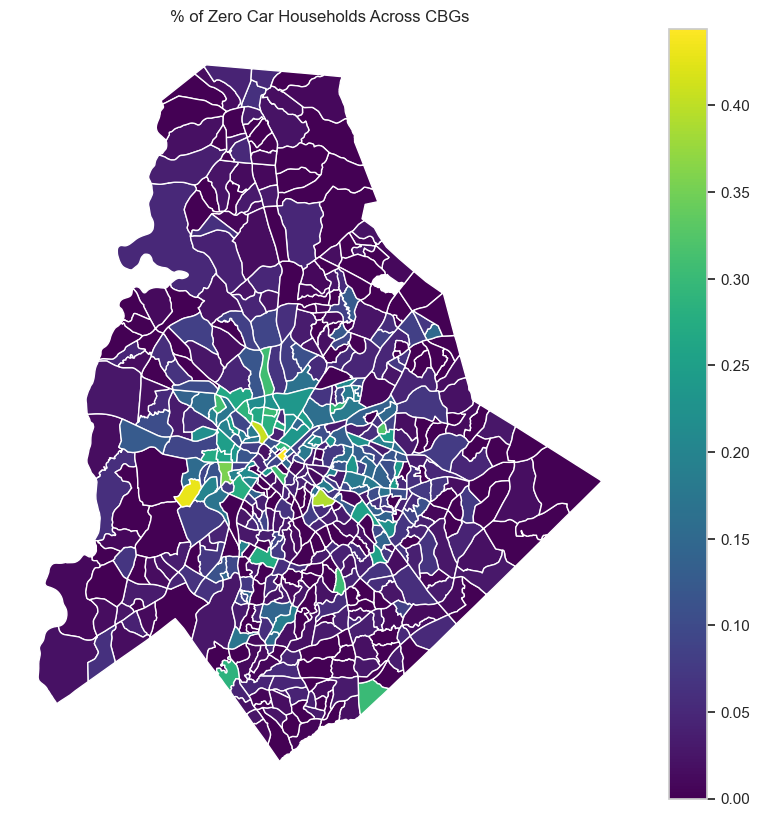

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column="Pct_AO0", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("% of Zero Car Households Across CBGs")
plt.axis("off")
plt.show()

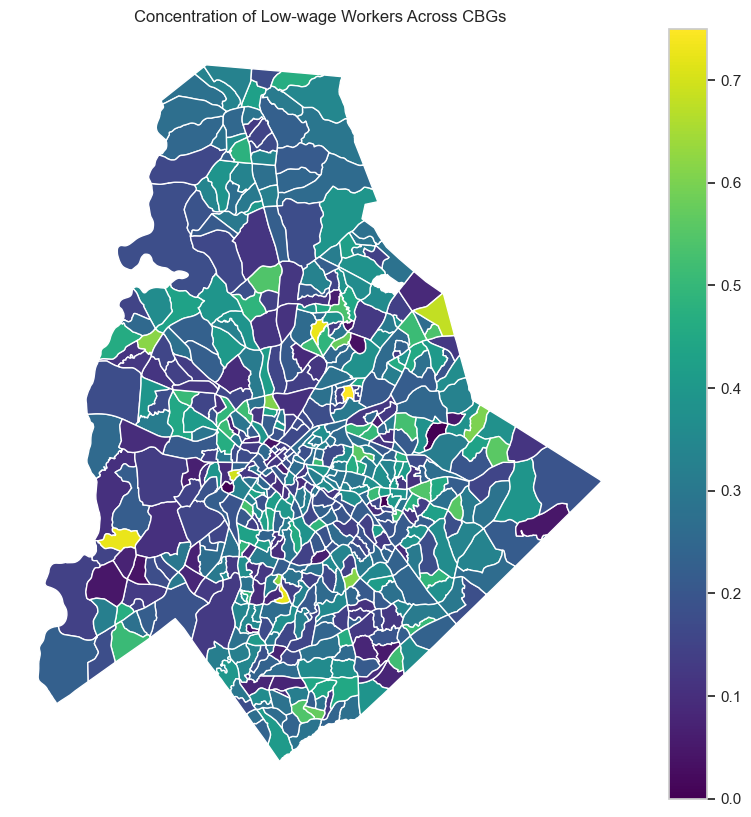

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column="E_PctLowWage", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("Concentration of Low-wage Workers Across CBGs")
plt.axis("off")
plt.show()

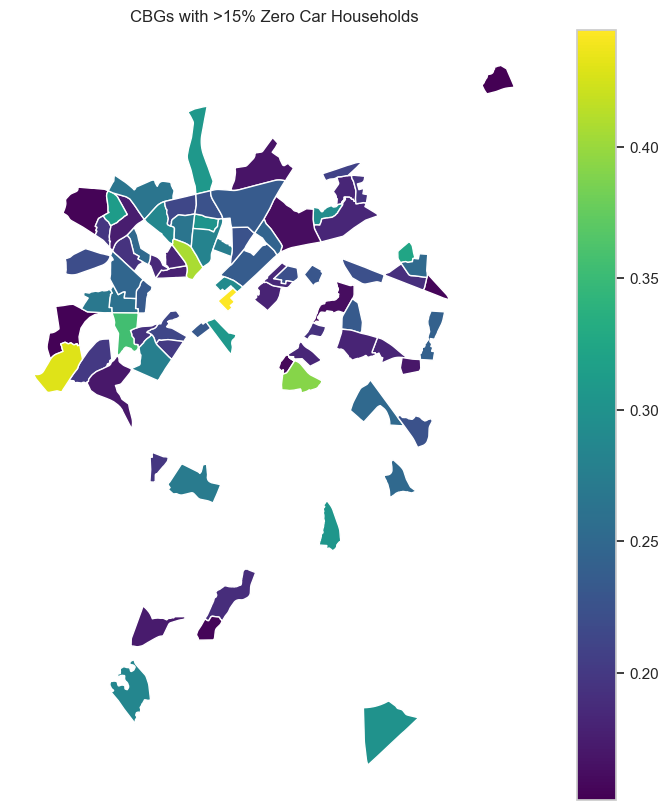

In [124]:
high_low_car = merged[merged["Pct_AO0"] > .15].copy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
high_low_car.plot(column="Pct_AO0", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("CBGs with >15% Zero Car Households")
plt.axis("off")
plt.show()

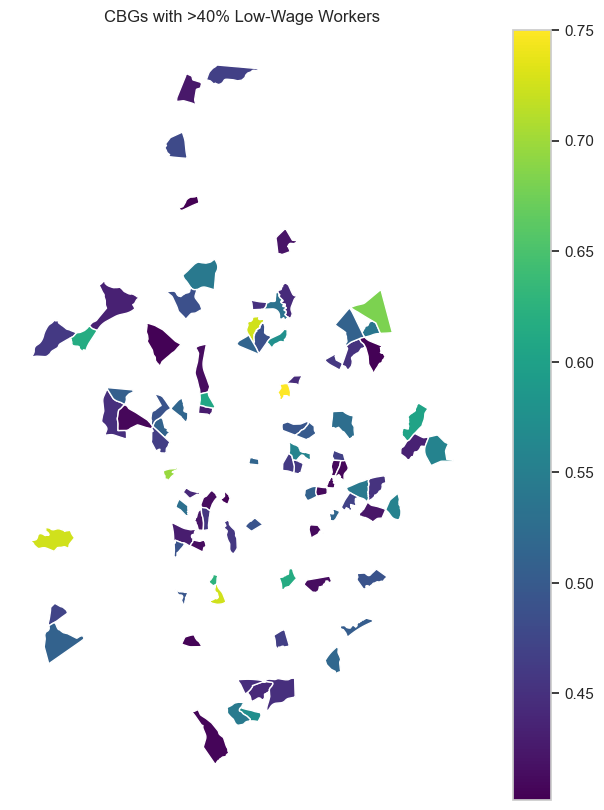

In [125]:
high_low_wage = merged[merged["E_PctLowWage"] > .4].copy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
high_low_wage.plot(column="E_PctLowWage", ax=ax, legend=True, cmap="viridis")
ax.set_facecolor('#ffffff')  # Set the background color of the chart area
fig.set_facecolor('#ffffff')
ax.set_title("CBGs with >40% Low-Wage Workers")
plt.axis("off")
plt.show()

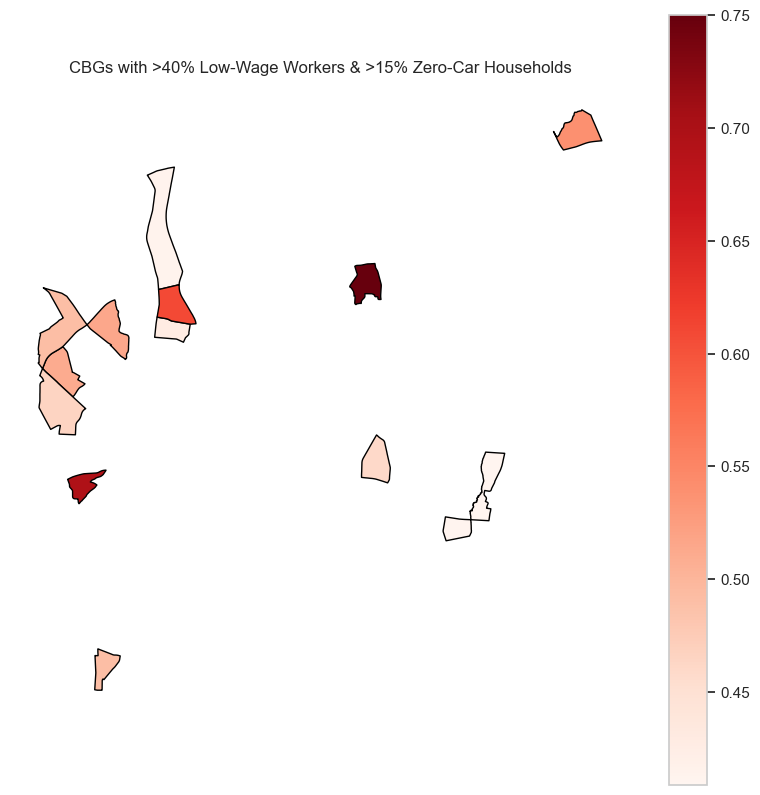

In [126]:
vulnerable_cbgs = merged[(merged["E_PctLowWage"] > .4) & (merged["Pct_AO0"] > .15)].copy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
vulnerable_cbgs.plot(column="E_PctLowWage", ax=ax, legend=True, cmap="Reds", edgecolor="black")
ax.set_facecolor('#ffffff')
fig.set_facecolor('#ffffff')
ax.set_title("CBGs with >40% Low-Wage Workers & >15% Zero-Car Households")
plt.axis("off")
plt.show()